In [1]:
from deepvisualinsight.MMS import MMS
import deepvisualinsight.utils as utils
import sys
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
import json
import tensorflow as tf

DATASET = "cifar10"
content_path = "/home/xianglin/projects/DVI_data/TemporalExp/resnet18_{}".format(DATASET)

sys.path.append(content_path)
from Model.model import *
net = resnet18()

classes = ("airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

mms = MMS(content_path, net, 1, 7, 1, 512, 10, classes, temperature=.3, batch_size=500, cmap="tab10", resolution=100, verbose=1, 
transfer_learning=True, attention=False, temporal=True, step3=False, split=-1, advance_border_gen=True, alpha=0.3, withoutB=False, attack_device="cuda:0")



2021-12-18 14:57:37.279132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 14:57:37.279913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 14:57:37.280695: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 14:57:37.281474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 14:57:37.286442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

Finish loading content!


In [2]:
prev_data = mms.get_epoch_train_repr_data(1)
curr_data = mms.get_epoch_train_repr_data(2)
dists = np.linalg.norm(prev_data - curr_data, axis=1)
dists.shape

(50000,)

In [3]:
encoder = mms.get_proj_model(1)
prev_embedding = encoder(prev_data).cpu().numpy()

encoder = mms.get_proj_model(2)
curr_embedding = encoder(curr_data).cpu().numpy()

embedding_dists = np.linalg.norm(prev_embedding-curr_embedding, axis=1)

2021-12-18 14:57:41.424114: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-18 14:57:41.654447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 14:57:41.655301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 14:57:41.656252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f49e5f5fa50>
Instructions for updating:
Use tf.identity instead.
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f49e4d612d0>


2021-12-18 14:57:43.333258: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [4]:
high_change = np.argsort(dists)
low_change= np.argsort(embedding_dists)
targets = np.intersect1d(high_change[49000:],low_change[49000:])
targets.shape

(134,)

In [9]:
targets = np.load("/home/xianglin/projects/git_space/SingleVisualization/wrong_pred.npy")

100%|██████████| 1/1 [00:00<00:00, 3368.92it/s]

Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f49d03b5d50>
Computing decision regions ...
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f49565e17d0>
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f49e603a850>


100%|██████████| 50/50 [00:00<00:00, 16488.34it/s]

Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f49e516d950>



100%|██████████| 1/1 [00:00<00:00, 3390.71it/s]

Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f495611d2d0>
Computing decision regions ...
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f49e31790d0>
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f49e26b7f50>


100%|██████████| 50/50 [00:00<00:00, 16378.88it/s]

Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f49e31848d0>



100%|██████████| 1/1 [00:00<00:00, 3418.34it/s]

Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f49e29ff310>
Computing decision regions ...
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f49e2724710>
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f49e2583910>


100%|██████████| 50/50 [00:00<00:00, 15665.59it/s]

Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f49e2a10850>


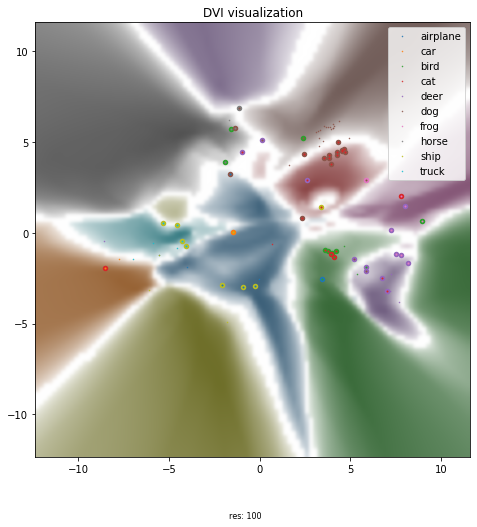

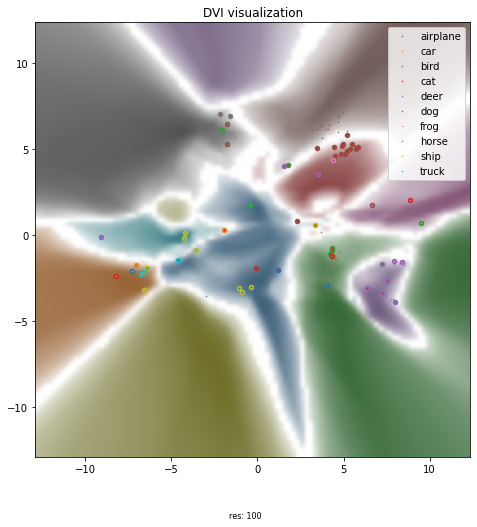

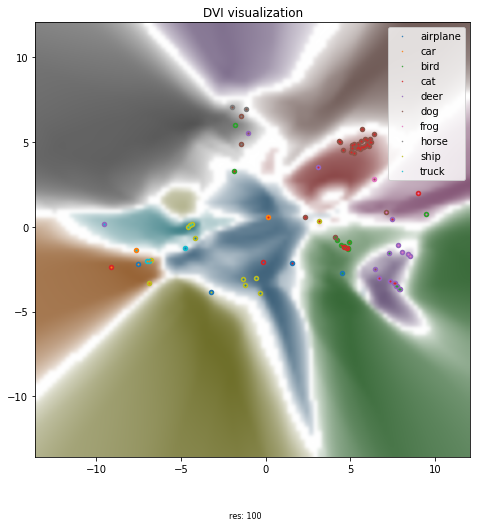

In [10]:
save_dir = "./result"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
for i in range(5, 8, 1):
    curr_data = mms.get_epoch_train_repr_data(i)
    curr_data = curr_data[targets]
    pred = mms.get_pred(i, curr_data)
    pred = np.argmax(pred, axis=1)
    labels = mms.get_epoch_train_labels(i)
    labels = labels[targets]
    mms.savefig_cus(i, curr_data, pred, labels, path=os.path.join(save_dir,"motivated_{}_{}.png".format(DATASET, i)))

In [6]:
from scipy.stats.stats import pearsonr
corr = pearsonr(dists, embedding_dists)
corr

(0.5158025328449392, 0.0)